**YOUR NAMES HERE**

Spring 2024

CS 443: Bio-inspired Machine Learning

# Project 4: Spiking Neural Networks

#### Week 2: Building a spiking neural network

### Reminder: AI Policy

To improve the quality of your learning and out of fairness to your hardworking classmates, AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions. This includes both written analysis, plotting, and code. I will only grade your work, not an AI's. I will stop grading your project if I notice AI-generated content (in any capacity).

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

plt.show()
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 5: Setting up for the spiking neural network

You will implement a **spiking neural network (SNN)** that will learn to classify MNIST via the STDP learning rule. You have already implemented key components last week and in the lab. This network will build on the code that you wrote.

The SNN will be a two-layer network with the following architecture
- Input layer (`InputLayer` class): Poisson encodes data sample into input spike trains.
- Recurrent layer (`RecurrentLayer` class): Integrates spikes from the input layer and each neuron sends inhibitory **recurrent** signals to all other neurons in the layer (not including itself).

Shared functionality between the layers is placed in the parent `Layer` class.

### 5a. Copy over files from lab

1. Copy over the `mnist.py` that you modified in the Poisson encoding lab.
2. Copy over the MNIST dataset folder into a `data` subfolder of this project.

### 5b. Make a JSON configuration file for your SNN

Make a JSON configuration file for debugging your two-layer spiking neural network (e.g. `net_params_debug.json`) and organize the following information needed to specify the spiking neural network that we will use to classify MNIST (*these parameters largely come from Diehl & Cook (2015); we are only using 3 recurrent layer neurons right now for debugging purposes*).

#### Input layer parameters
- Number of neurons: 11
- Trace decay rate: 0.95
- Number of time steps: 350

#### Recurrent layer parameters
- Number of neurons: 3
- Trace decay rate: 0.95
- Rest voltage: -65 mV
- Reset voltage: -60 mV
- Spike threshold: -52 mV
- Voltage (membrane potential) decay rate: 0.99
- Refractory period length: 3 time steps
- Increment to adaptive threshold everytime there is a spike: 0.05 mV
- Adaptive threshold decay rate (if there is no spike): 0.999999
- Gain on the recurrent weights (within-layer inhibition): 100
- Maximum input-to-excitatory learnable weights value: 0.3
- Normalization value for total input-to-excitatory learnable weights: 78.4
- STDP weight update (-) learning rate: 0.1
- STDP weight update (+) learning rate: 0.5


You should have parameters related to the same layer grouped into certain named sections (for the purposes of test code), but it is otherwise up to you how you would like to organize the file. The layer sections should be called `input_layer`, and `recurrent_layer`. Here is a basic template (please use better parameter names!)*:

```json
{
    "input_layer":
    {
        "param1": "blah1",
        "param2": "blah2"
    },
    "recurrent_layer":
    {
        "param1": "blah3",
        "param2": "blah4"
    }
}
```

### 5c. Load in your SNN config file in the cell below

Name the Python dictionary `params` for test code purposes.

In [2]:
with open("net_params_debug.json", "r") as file:
    params = json.load(file)
    
print(params)

{'input_layer': {'num_neurons': 11, 'trace_decay_rate': 0.95, 'num_time_steps': 350}, 'recurrent_layer': {'num_neurons': 3, 'trace_decay_rate': 0.95, 'v_decay_rate': 0.99, 'v_rest': -65, 'v_reset': -60, 'spike_thre': -52, 'voltage_decay_rate': 0.99, 'refrac_period': 3, 'adaptive_threshold': 0.05, 'adaptive_decay_rate': 0.999999, 'gain_wts': 100, 'max_wts': 0.3, 'norm_wts': 78.4, 'wts_update_+': 0.5, 'wts_update_-': 0.1}}


## Task 6:  Implement `Layer` and `InputLayer` classes

These are the first two classes in `snn.py`.

In [3]:
from snn import Layer, InputLayer

#### Test: `Layer`

In [4]:
test_layer = Layer(num_neurons=11, params=params['input_layer'])
print(f'Number of neurons are {test_layer.get_num_units()} and should be 11')
print('Initializing the layer...', end='')
test_layer.initialize_state()
print('done!')
print(f'Your spike record for the neurons is initialized? {np.all(test_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is initialized? {np.all(test_layer.get_trace() == 0)}')
print(f'Your spike record shape is {test_layer.get_spikes().shape} and should be (11,)')
print(f'Your trace shape is {test_layer.get_trace().shape} and should be (11,)')
test_spikes = test_layer.get_spikes()
test_trace = test_layer.get_trace()
test_spikes[1] = 1
test_trace[0] = 0.5
test_layer.set_spikes(test_spikes)
test_layer.set_trace(test_trace)
print('Resetting the layer state...', end='')
test_layer.reset_state()
print('done!')
print(f'Your spike record for the neurons is reset? {np.all(test_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is reset? {np.all(test_layer.get_trace() == 0)}')



Number of neurons are 11 and should be 11
Initializing the layer...done!
Your spike record for the neurons is initialized? True
Your trace for the neurons is initialized? True
Your spike record shape is (11,) and should be (11,)
Your trace shape is (11,) and should be (11,)
Resetting the layer state...done!
Your spike record for the neurons is reset? True
Your trace for the neurons is reset? True


#### Test: `InputLayer`

In [5]:
print('Testing general layer functionality:')
print(60*'-')
test_layer = InputLayer(params=params['input_layer'])
print(f'Number of neurons are {test_layer.get_num_units()} and should be 11.')
print('Initializing the layer...', end='')
test_layer.initialize_state()
print('done!')
print(f'Your spike record for the neurons is initialized? {np.all(test_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is initialized? {np.all(test_layer.get_trace() == 0)}')
print(f'The spikes of every neuron is accounted for? {len(test_layer.get_spikes()) == 11}')
print(f'The trace of every neuron is accounted for? {len(test_layer.get_trace()) == 11}')
test_spikes = test_layer.get_spikes()
test_trace = test_layer.get_trace()
test_spikes[10] = 1
test_trace[3] = 0.25
test_layer.set_spikes(test_spikes)
test_layer.set_trace(test_trace)
print('Resetting the layer state...', end='')
test_layer.reset_state()
print('done!')
print(f'Your spike record for the neurons is reset? {np.all(test_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is reset? {np.all(test_layer.get_trace() == 0)}')
print(f'The spikes of every neuron is accounted for? {len(test_layer.get_spikes()) == 11}')
print(f'The trace of every neuron is accounted for? {len(test_layer.get_trace()) == 11}')

Testing general layer functionality:
------------------------------------------------------------
Number of neurons are 11 and should be 11.
Initializing the layer...done!
Your spike record for the neurons is initialized? True
Your trace for the neurons is initialized? True
The spikes of every neuron is accounted for? True
The trace of every neuron is accounted for? True
Resetting the layer state...done!
Your spike record for the neurons is reset? True
Your trace for the neurons is reset? True
The spikes of every neuron is accounted for? True
The trace of every neuron is accounted for? True


In [6]:
print('\nTesting input layer:')
print(60*'-')
test_spikes = test_layer.get_spikes()
test_spikes = test_spikes.copy()
test_spikes[2] = 1
test_spikes[4] = 1
print(f'Doing forward pass with the following spike input to {test_layer.get_num_units()} Input layer neurons:\n{test_spikes.astype(int)}')
test_layer.forward(test_spikes)
curr_spikes = test_layer.get_spikes()
curr_trace = test_layer.get_trace()
print(f'Neurons {np.nonzero(curr_spikes == 1)[0]} spiked! Neurons [2 4] should have.')
print(f'Neurons {np.nonzero(curr_spikes == 0)[0]} did not spike!\nNeurons [ 0  1  3  5  6  7  8  9 10] should not have.')
print(f'The trace of the neurons is now\n{curr_trace}\nand should be\n[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]')

print()
print('Now doing two forward passes on input layer with 0 input.')
test_spikes[2] = 0
test_spikes[4] = 0
test_layer.forward(test_spikes)
test_layer.forward(test_spikes)
curr_spikes = test_layer.get_spikes()
curr_trace = test_layer.get_trace()
print(f'Neurons {np.nonzero(curr_spikes == 0)[0]} did not spike!\nNeurons [ 0  1  2  3  4  5  6  7  8  9 10] should not have.')
print(f'The trace of the neurons is now\n{curr_trace}\nand should be\n[0.    0.    0.902 0.    0.902 0.    0.    0.    0.    0.    0.   ]')


Testing input layer:
------------------------------------------------------------
Doing forward pass with the following spike input to 11 Input layer neurons:
[0 0 1 0 1 0 0 0 0 0 0]
Neurons [2 4] spiked! Neurons [2 4] should have.
Neurons [ 0  1  3  5  6  7  8  9 10] did not spike!
Neurons [ 0  1  3  5  6  7  8  9 10] should not have.
The trace of the neurons is now
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
and should be
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]

Now doing two forward passes on input layer with 0 input.
Neurons [ 0  1  2  3  4  5  6  7  8  9 10] did not spike!
Neurons [ 0  1  2  3  4  5  6  7  8  9 10] should not have.
The trace of the neurons is now
[0.    0.    0.902 0.    0.902 0.    0.    0.    0.    0.    0.   ]
and should be
[0.    0.    0.902 0.    0.902 0.    0.    0.    0.    0.    0.   ]


#### Test: `poisson_encode`

Due to randomness / potential differences in implementation, if the total spike counts do not match below, make sure that the raster plots match qualitatively (e.g. fairly uniform spike density in 1st raster, higher density of spikes on the bottom half of the 2nd raster).

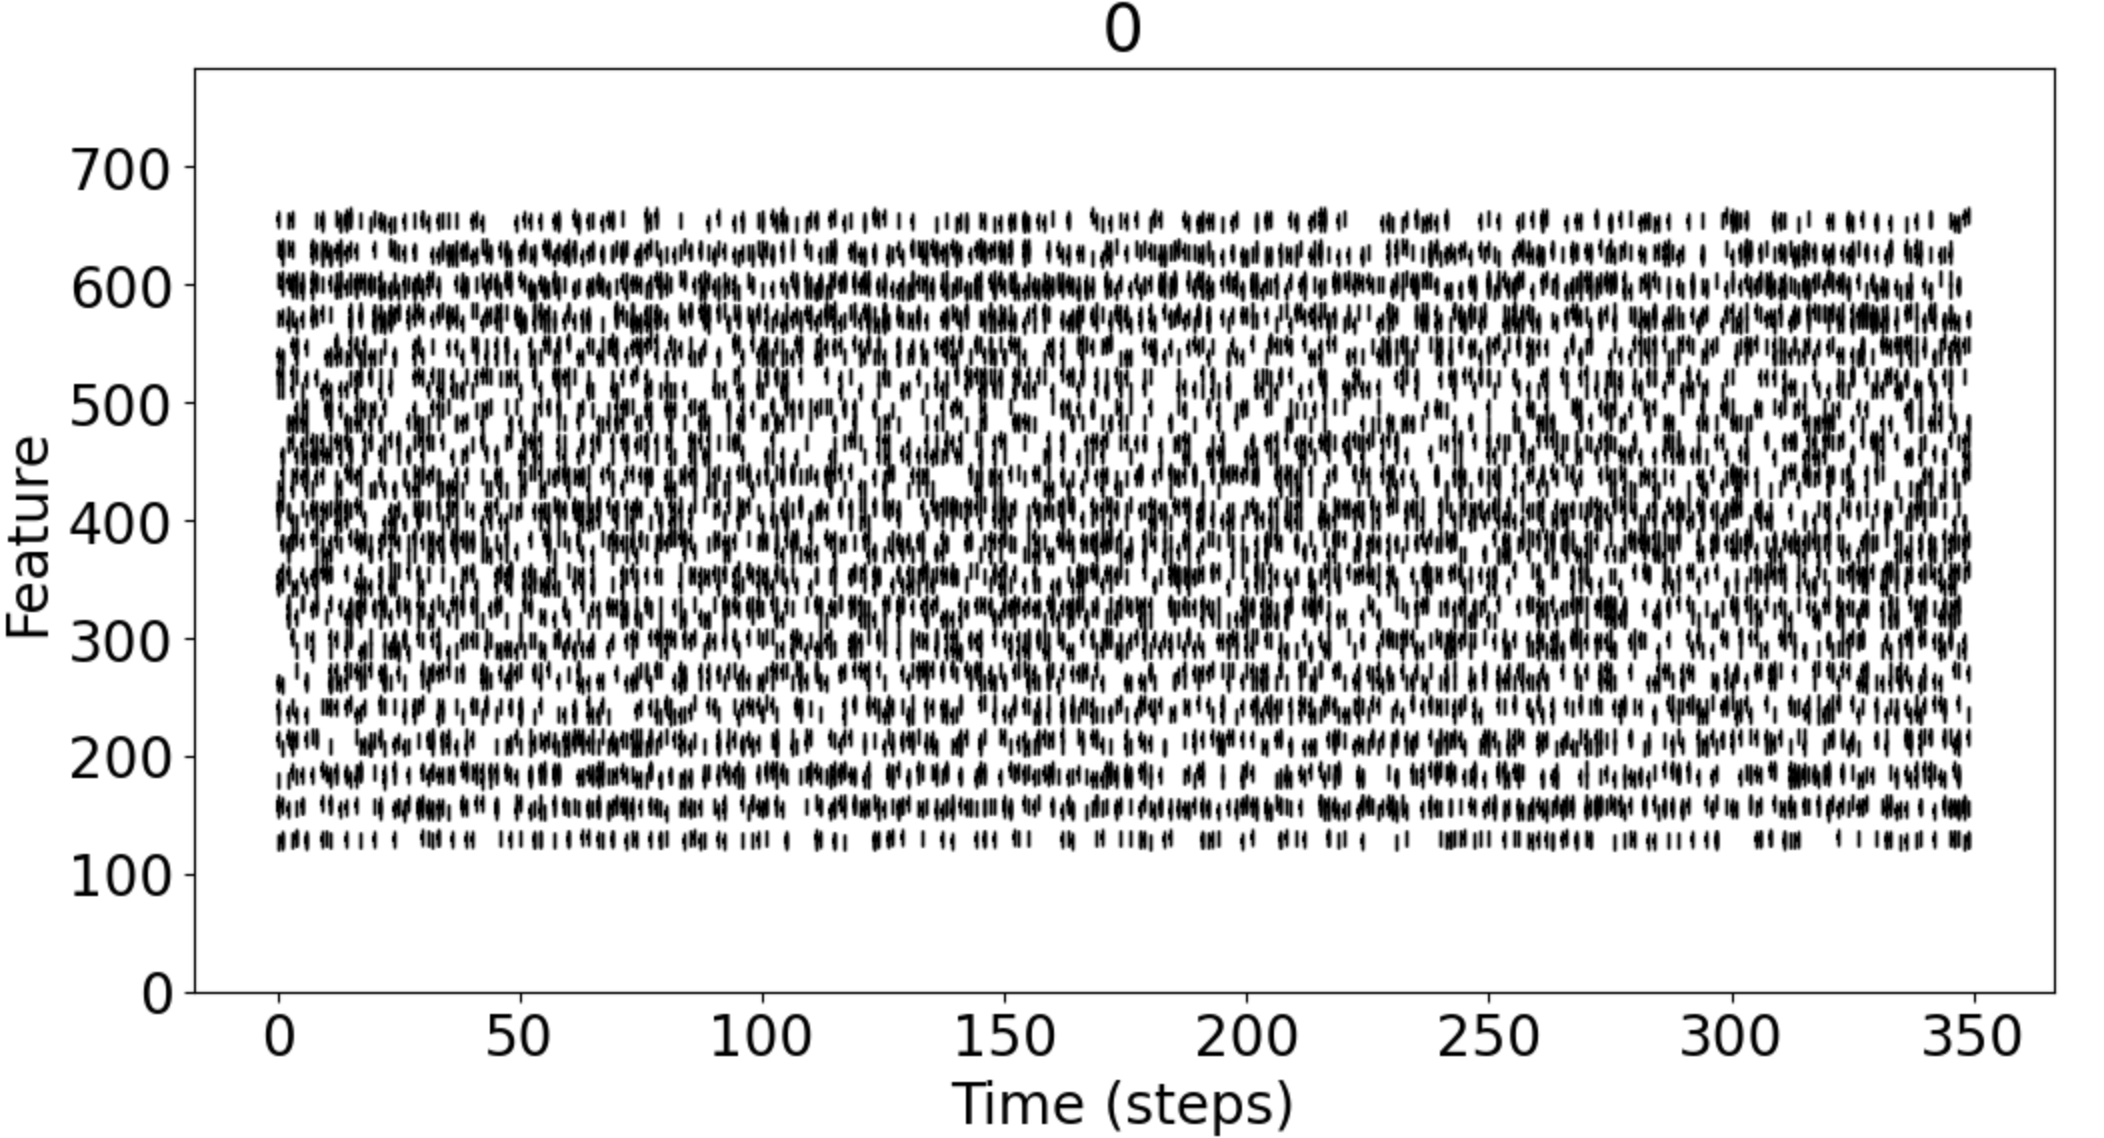

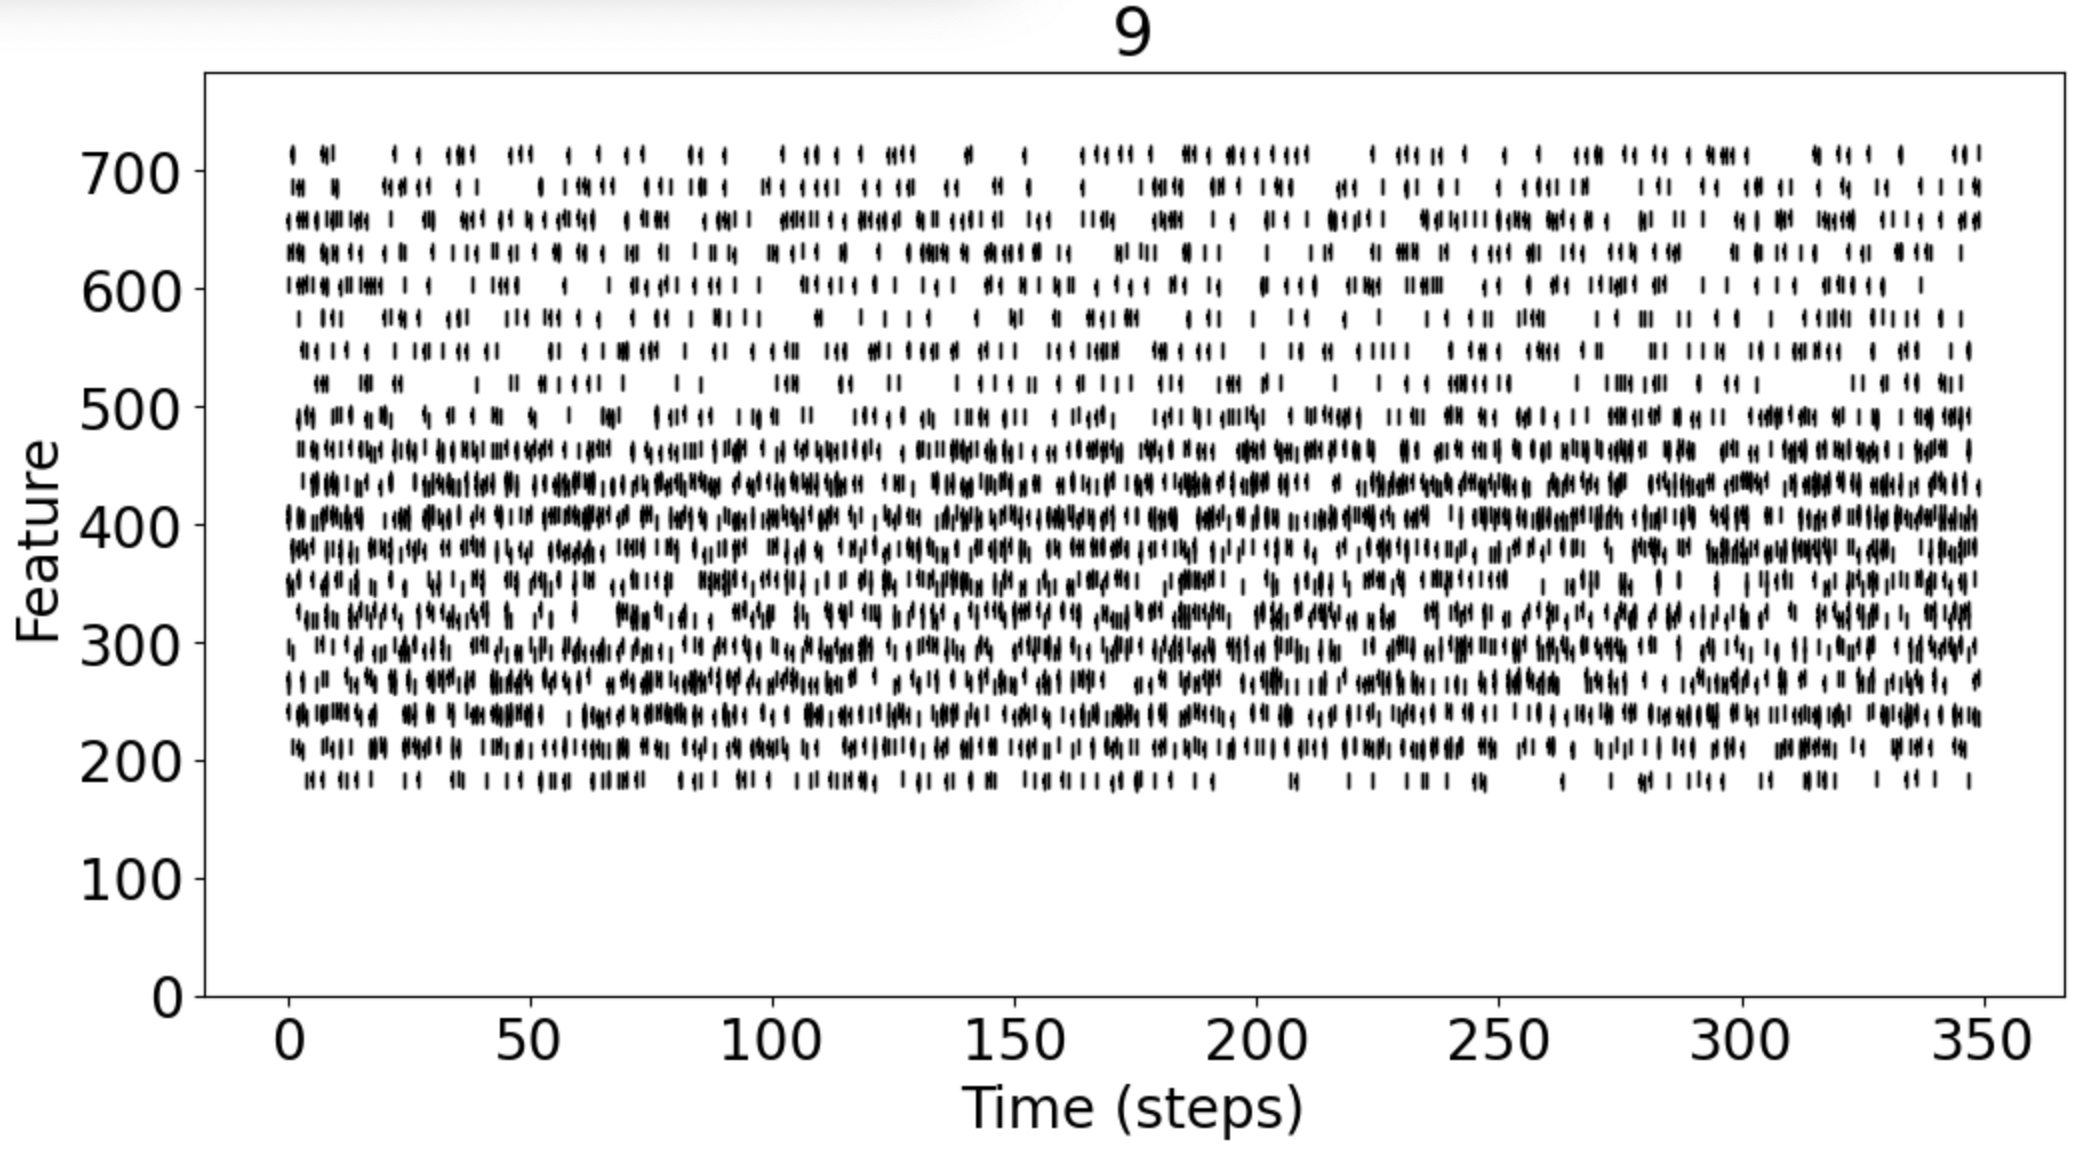

In [7]:
from viz import raster_plot

Debug MNIST Sample 0 total spikes across all input neurons: 7927 and should be 7927


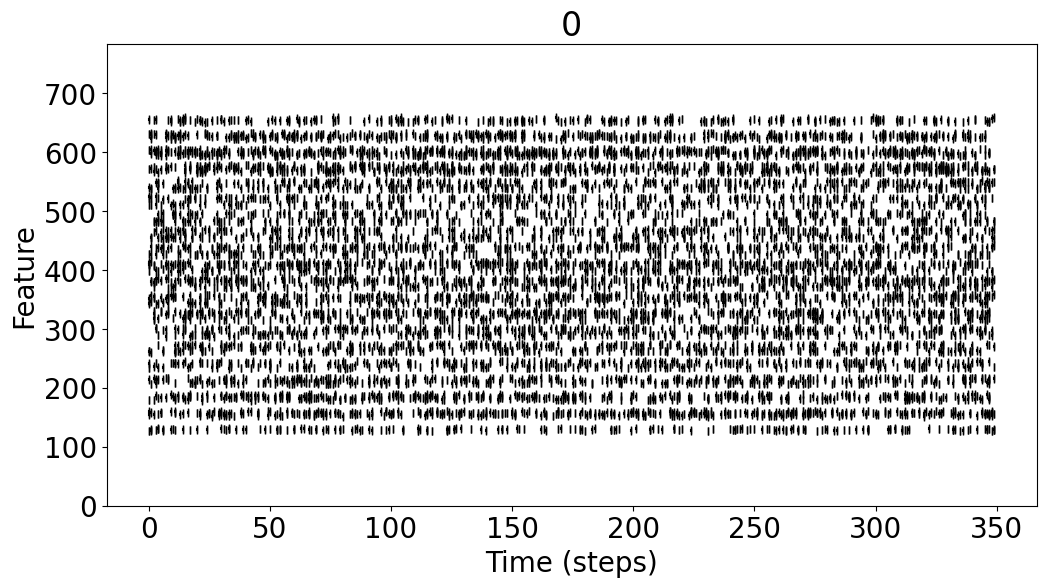

Debug MNIST Sample 1 total spikes across all input neurons: 4510 and should be 4510


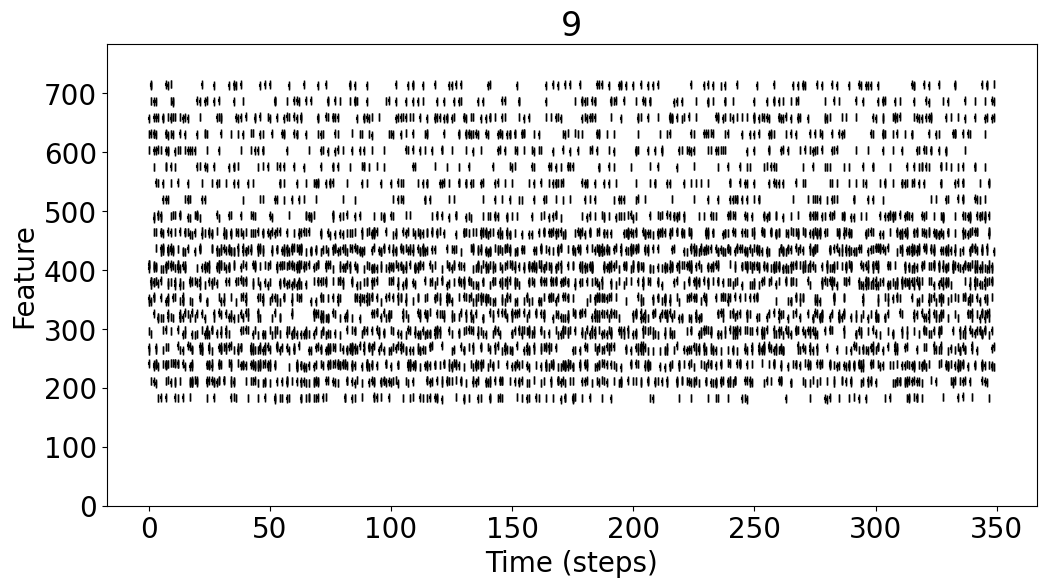

In [9]:
mnist_debug = np.load('data/mnist/mnist_debug.npz')

params['n_neurons'] = 784  # CHANGE STRING TO MATCH YOUR CONFIG FILE
input_mnist_layer = InputLayer(params=params['input_layer'])

debug_total_spikes = [7927, 4510]
for i in range(2):
    np.random.seed(0)
    samp_enc = np.squeeze(input_mnist_layer.poisson_encode(mnist_debug['x_debug'][i]))
    print(f'Debug MNIST Sample {i} total spikes across all input neurons: {samp_enc.sum()} and should be {debug_total_spikes[i]}')
    raster_plot(samp_enc, mnist_debug['y_debug'][i])
params['n_neurons'] = 11  # CHANGE STRING TO MATCH YOUR CONFIG FILE

## Task 7:  Recurrent Layer of LIF Neurons

The `RecurrentLayer` class inherits from `Layer` and "owns" the set of weights between the `InputLayer` (source layer) and `RecurrentLayer` (destination layer) that is adjusted using STDP learning. Neurons in a `RecurrentLayer` layer have the following characteristics:
- Learnable weights between the layer below (Input Layer) and itself (`in_wts`).
- Each neuron sends inhibitory signal to *all other neurons* in the same `RecurrentLayer`, but not itself. The strength of this recurrent inhibition is controlled by fixed (non-learnable) wts arranged in an **off-surround** configuration.
- Refractory period
- Trace
- Adaptive threshold.

In summary, the neurons in `RecurrentLayer` act much like your neurons in `LIFLayer`. New properties are:
- The fixed recurrent weights among neurons within the same layer.
- The STDP learning rule to update the Input Layer → Recurrent Layer weights.

In [10]:
from snn import RecurrentLayer

### 7a. Implement `RecurrentLayer` class constructor, initialization, set/get methods

For this part, everything up until `net_in`.

In [11]:
np.random.seed(0)
r_layer = RecurrentLayer(num_neurons_prev_layer=11, params=params['recurrent_layer'])

#### (i) Test: General layer properties

In [12]:
print('Testing general layer functionality:')
print(60*'-')
print(f'Number of neurons are {r_layer.get_num_units()} and should be 3.')
print('Initializing the layer...', end='')
r_layer.initialize_state()
print('done!')
print(f'Your spike record for the neurons is initialized? {np.all(r_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is initialized? {np.all(r_layer.get_trace() == 0)}')
print(f'The spikes of every neuron is accounted for? {len(r_layer.get_spikes()) == 3}')
print(f'The trace of every neuron is accounted for? {len(r_layer.get_trace()) == 3}')
test_spikes = r_layer.get_spikes()
test_trace = r_layer.get_trace()
test_spikes[1] = 1
test_trace[0] = 0.25
r_layer.set_spikes(test_spikes)
r_layer.set_trace(test_trace)
print('Resetting the layer state...', end='')
r_layer.reset_state()
print('done!')
print(f'Your spike record for the neurons is reset? {np.all(r_layer.get_spikes() == 0)}')
print(f'Your trace for the neurons is reset? {np.all(r_layer.get_trace() == 0)}')
print()
print(f'Your voltages are: {r_layer.get_v()} and should be [-65. -65. -65.]')
print(f'Your refractory counts are: {r_layer.get_refractory_count()} and should be [0 0 0]')
print('Changing the voltage and refractory counts...', end='')
r_layer.set_v(np.array([1, 1, 1]))
r_layer.set_refractory_count(np.array([2, 2, 2]))
print('done!')
print('Resetting the layer state...', end='')
r_layer.reset_state()
print('done!')
print(f'Your voltages are: {r_layer.get_v()} and should be [-65. -65. -65.]')
print(f'Your refractory counts are: {r_layer.get_refractory_count()} and should be [0 0 0]')

Testing general layer functionality:
------------------------------------------------------------
Number of neurons are 3 and should be 3.
Initializing the layer...done!
Your spike record for the neurons is initialized? True
Your trace for the neurons is initialized? True
The spikes of every neuron is accounted for? True
The trace of every neuron is accounted for? True
Resetting the layer state...done!
Your spike record for the neurons is reset? True
Your trace for the neurons is reset? True

Your voltages are: [-65. -65. -65.] and should be [-65. -65. -65.]
Your refractory counts are: [0. 0. 0.] and should be [0 0 0]
Changing the voltage and refractory counts...done!
Resetting the layer state...done!
Your voltages are: [-65. -65. -65.] and should be [-65. -65. -65.]
Your refractory counts are: [0. 0. 0.] and should be [0 0 0]


#### (ii) Test: `RecurrentLayer` layer constructor

In [13]:
print('Testing RecurrentLayer layer constructor:')
print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
print('done!')
print(f'Your adaptive thresholds are: {r_layer.get_adaptive_threshold()} and should be [0. 0. 0.]')
print(f'Your InputLayer -> RecLayer wts (in_wts) are:\n{r_layer.get_in_wts()}')
print('and should be:')
print('''[[0.165 0.215 0.181]
 [0.163 0.127 0.194]
 [0.131 0.268 0.289]
 [0.115 0.238 0.159]
 [0.17  0.278 0.021]
 [0.026 0.006 0.25 ]
 [0.233 0.261 0.294]
 [0.24  0.138 0.234]
 [0.035 0.192 0.043]
 [0.283 0.157 0.124]
 [0.079 0.232 0.137]]''')

Testing RecurrentLayer layer constructor:
------------------------------------------------------------
Resetting the layer...done!
Your adaptive thresholds are: [0. 0. 0.] and should be [0. 0. 0.]
Your InputLayer -> RecLayer wts (in_wts) are:
[[0.165 0.215 0.181]
 [0.163 0.127 0.194]
 [0.131 0.268 0.289]
 [0.115 0.238 0.159]
 [0.17  0.278 0.021]
 [0.026 0.006 0.25 ]
 [0.233 0.261 0.294]
 [0.24  0.138 0.234]
 [0.035 0.192 0.043]
 [0.283 0.157 0.124]
 [0.079 0.232 0.137]]
and should be:
[[0.165 0.215 0.181]
 [0.163 0.127 0.194]
 [0.131 0.268 0.289]
 [0.115 0.238 0.159]
 [0.17  0.278 0.021]
 [0.026 0.006 0.25 ]
 [0.233 0.261 0.294]
 [0.24  0.138 0.234]
 [0.035 0.192 0.043]
 [0.283 0.157 0.124]
 [0.079 0.232 0.137]]


In [14]:
print(f'Your RecLayer -> RecLayer wts (wts_rec) are:\n{r_layer.get_recurrent_wts()}')
print('and should be:')
print('''[[  -0. -100. -100.]
 [-100.   -0. -100.]
 [-100. -100.   -0.]]''')

Your RecLayer -> RecLayer wts (wts_rec) are:
[[   0. -100. -100.]
 [-100.    0. -100.]
 [-100. -100.    0.]]
and should be:
[[  -0. -100. -100.]
 [-100.   -0. -100.]
 [-100. -100.   -0.]]


### 7b. Implement `RecurrentLayer` `net_in`

Remember to integrate spikes from the layer below (Input layer) and also spikes sent from other neurons in the layer.

#### Test: `RecurrentLayer` `net_in`

In [15]:
print('Testing RecurrentLayer net_act:')
print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
print('Test: Calling net_in with test spike input: ', end='')
np.random.seed(0)
test_input = np.random.choice([True, False], size=11)
test_net_in = r_layer.net_in(test_input)
print('done!')
print(f'Your net_in is {test_net_in} and should be [0.28  0.452 0.339]')

Testing RecurrentLayer net_act:
------------------------------------------------------------
Resetting the layer...done!
Test: Calling net_in with test spike input: done!
Your net_in is [0.28  0.452 0.339] and should be [0.28  0.452 0.339]


### 7c. Implement `RecurrentLayer` `net_act`

This should mostly be a copy-paste from your `lif_neurons.py`.

#### Test: `RecurrentLayer` `net_act`

In [16]:
print('Testing RecurrentLayer net_act:')
print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
print('Test 1: Calling net_act with test net_in: ', end='')
r_layer.set_is_learning(True)
r_layer.net_act(np.array([0.3, 0.4, 0.5]))
print('done!')
print(f'Your voltage is {r_layer.get_v()} and should be [-64.7 -64.6 -64.5]')
print(f'Your refractory count is {r_layer.get_refractory_count()} and should be [0 0 0]')
print(f'Your spikes are {r_layer.get_spikes()} and should be [False False False]')
print(f'Your traces are {r_layer.get_trace()} and should be [0. 0. 0.]')
print(f'Your adaptive threshold is {r_layer.get_adaptive_threshold()} and should be [0. 0. 0.]')
r_layer.set_is_learning(False)

Testing RecurrentLayer net_act:
------------------------------------------------------------
Resetting the layer...done!
Test 1: Calling net_act with test net_in: done!
Your voltage is [-64.7 -64.6 -64.5] and should be [-64.7 -64.6 -64.5]
Your refractory count is [0. 0. 0.] and should be [0 0 0]
Your spikes are [False False False] and should be [False False False]
Your traces are [0. 0. 0.] and should be [0. 0. 0.]
Your adaptive threshold is [0. 0. 0.] and should be [0. 0. 0.]


In [17]:
print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
r_layer.set_is_learning(True)
print('Test 2a: Calling net_act with new test net_in: ', end='')
r_layer.net_act(np.array([15, 10.25, 9]))
print('done!')
print(f'Your voltage is {r_layer.get_v()} and should be [-60.   -54.75 -56.  ]')
print(f'Your refractory count is {r_layer.get_refractory_count()} and should be [3 0 0]')
print(f'Your spikes are {r_layer.get_spikes()} and should be [ True False False]')
print(f'Your traces are {r_layer.get_trace()} and should be [1. 0. 0.]')
print(f'Your adaptive threshold is {r_layer.get_adaptive_threshold()} and should be [0.05 0.   0.  ]')
print(60*'-')
print('Test 2b: Calling net_act again with new test net_in: ', end='')
np.random.seed(1)
r_layer.net_act(np.array([15.5, 11.5, 1.25]))
print('done!')
print(f'Your voltage is {r_layer.get_v()} and should be [-60.05 -60.   -54.84]')
print(f'Your refractory count is {r_layer.get_refractory_count()} and should be [2 3 0]')
print(f'Your spikes are {r_layer.get_spikes()} and should be [False  True False]')
print(f'Your traces are {r_layer.get_trace()} and should be [0.95 1.   0.  ]')
print(f'Your adaptive threshold is {r_layer.get_adaptive_threshold()} and should be [0.05   0.05 0.  ]')
r_layer.set_is_learning(False)

------------------------------------------------------------
Resetting the layer...done!
Test 2a: Calling net_act with new test net_in: done!
Your voltage is [-60.   -54.75 -56.  ] and should be [-60.   -54.75 -56.  ]
Your refractory count is [3. 0. 0.] and should be [3 0 0]
Your spikes are [ True False False] and should be [ True False False]
Your traces are [1. 0. 0.] and should be [1. 0. 0.]
Your adaptive threshold is [0.05 0.   0.  ] and should be [0.05 0.   0.  ]
------------------------------------------------------------
Test 2b: Calling net_act again with new test net_in: done!
Your voltage is [-60.05 -60.   -54.84] and should be [-60.05 -60.   -54.84]
Your refractory count is [2. 3. 0.] and should be [2 3 0]
Your spikes are [False  True False] and should be [False  True False]
Your traces are [0.95 1.   0.  ] and should be [0.95 1.   0.  ]
Your adaptive threshold is [0.05 0.05 0.  ] and should be [0.05   0.05 0.  ]


Now testing with learning mode off (no adaptive thresholds used):

In [18]:
np.random.seed(1)
print('Test 3a: Calling net_act again not in learning mode after reseting state: ', end='')
r_layer.reset_state()
r_layer.net_act(np.array([15.5, 11.5, 10.25]))
print('done!')
print(f'Your voltage is {r_layer.get_v()} and should be  [-60.   -53.5  -54.75]')
print(f'Your refractory count is {r_layer.get_refractory_count()} and should be [3 0 0]')
print(f'Your spikes are {r_layer.get_spikes()} and should be [ True False False]')
print(f'Your traces are {r_layer.get_trace()} and should be [1. 0. 0.]')
print(f'Your adaptive threshold is {r_layer.get_adaptive_threshold()} and should be [0.05   0.05 0.  ]')

print(60*'-')
np.random.seed(1)
print('Test 3b: Calling net_act again not in learning mode after reseting state + thresholds: ', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
r_layer.net_act(np.array([15.5, 11.5, 10.25]))
print('done!')
print(f'Your voltage is {r_layer.get_v()} and should be  [-60.   -53.5  -54.75]')
print(f'Your refractory count is {r_layer.get_refractory_count()} and should be [3 0 0]')
print(f'Your spikes are {r_layer.get_spikes()} and should be [ True False False]')
print(f'Your traces are {r_layer.get_trace()} and should be [1. 0. 0.]')
print(f'Your adaptive threshold is {r_layer.get_adaptive_threshold()} and should be [0. 0. 0.]')

Test 3a: Calling net_act again not in learning mode after reseting state: done!
Your voltage is [-60.   -53.5  -54.75] and should be  [-60.   -53.5  -54.75]
Your refractory count is [3. 0. 0.] and should be [3 0 0]
Your spikes are [ True False False] and should be [ True False False]
Your traces are [1. 0. 0.] and should be [1. 0. 0.]
Your adaptive threshold is [0.05 0.05 0.  ] and should be [0.05   0.05 0.  ]
------------------------------------------------------------
Test 3b: Calling net_act again not in learning mode after reseting state + thresholds: done!
Your voltage is [-60.   -53.5  -54.75] and should be  [-60.   -53.5  -54.75]
Your refractory count is [3. 0. 0.] and should be [3 0 0]
Your spikes are [ True False False] and should be [ True False False]
Your traces are [1. 0. 0.] and should be [1. 0. 0.]
Your adaptive threshold is [0. 0. 0.] and should be [0. 0. 0.]


### 7d. Implement `RecurrentLayer` `forward`

#### Test: ` RecurrentLayer` layer `forward`

In [19]:
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')

wts_in = np.array([[0.165, 0.215, 0.181],
                   [0.163, 0.127, 0.194],
                   [0.131, 0.268, 0.289],
                   [0.115, 0.238, 0.159],
                   [0.17 , 0.278, 0.021],
                   [0.026, 0.006, 0.25 ],
                   [0.233, 0.261, 0.294],
                   [0.24 , 0.138, 0.234],
                   [0.035, 0.192, 0.043],
                   [0.283, 0.157, 0.124],
                   [0.079, 0.232, 0.137]])
r_layer.set_in_wts(10*wts_in)

print('Test 1: Calling forward...', end='')
np.random.seed(0)
r_layer.set_is_learning(True)
test_input = np.array(11*[True])
test_1_spks = r_layer.forward(test_input)
print('done!')
print(f'Spikes are: {test_1_spks} and should be True False False]')

print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
print('Test 2: Calling forward twice to simulate recurrent signals...', end='')
np.random.seed(0)
for i in range(5):
    test_2_spks = r_layer.forward(test_input)
print('done!')
print(f'Spikes are: {test_2_spks} and should be [False True False]')

# print(60*'-')
print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
print('Test 3: Calling forward with weaker input...', end='')
np.random.seed(0)
test_2_spks = r_layer.forward(np.array([False, False, False, True, False, False, False, True, False, False, True]))
print('done!')
print(f'Spikes are: {test_2_spks} and should be [False False False]')

r_layer.set_is_learning(False)
r_layer.set_in_wts(wts_in)

Resetting the layer...done!
Test 1: Calling forward...done!
Spikes are: [ True False False] and should be True False False]
------------------------------------------------------------
Resetting the layer...done!
Test 2: Calling forward twice to simulate recurrent signals...done!
Spikes are: [False  True False] and should be [False True False]
Resetting the layer...done!
Test 3: Calling forward with weaker input...done!
Spikes are: [False False False] and should be [False False False]


### 7e. Implement `RecurrentLayer` weight update (STDP learning rule)

Implement the following methods:
- `update_wts`: Updates the weights using STDP
- `normalize_wts`: Normalize the weights

The weight update has two components based on the relative spike timings (*causality*) between the pre-synaptic and post-synaptic neurons:
1. **(-) component:** Decrease the weight when the Pre-synaptic neuron fired and the Post-synaptic neuron fired earlier.
2. **(+) component:** Increase the weight when the Post-synaptic neuron fired and the Pre-synaptic neuron fired earlier.

Remember that this can be computed as a two-step matrix multiplication involving:
- The pre-synaptic neuron spikes and trace.
- The post-synaptic neuron spikes and trace.

#### Test: `RecurrentLayer` layer `update_wts` and `normalize_wts`

In [20]:
r_layer.set_is_learning(True)
wts_in = np.array([[0.165, 0.215, 0.181],
                   [0.163, 0.127, 0.194],
                   [0.131, 0.268, 0.289],
                   [0.115, 0.238, 0.159],
                   [0.17 , 0.278, 0.021],
                   [0.026, 0.006, 0.25 ],
                   [0.233, 0.261, 0.294],
                   [0.24 , 0.138, 0.234],
                   [0.035, 0.192, 0.043],
                   [0.283, 0.157, 0.124],
                   [0.079, 0.232, 0.137]])
r_layer.set_in_wts(wts_in)

print('Resetting the layer...', end='')
r_layer.reset_state()
r_layer.reset_adaptive_threshold()
print('done!')
print('Test 1: Calling update_wts...', end='')
r_layer.set_trace(np.array([1, 0.75, 0]))
r_layer.set_spikes(np.array([1, 0, 0]))
test_x_in = np.array([False, True, False, True, True, False, False, True, False, False, True])
np.random.seed(0)
test_trace_in = np.random.random(11)
r_layer.update_wts(np.array(test_x_in), test_trace_in)
print('done!')

print(f'Your wts after update 1 are\n{r_layer.get_in_wts()}\nand should be:')
print('''[[0.439 0.215 0.181]
 [0.421 0.052 0.194]
 [0.432 0.268 0.289]
 [0.287 0.163 0.159]
 [0.282 0.203 0.021]
 [0.349 0.006 0.25 ]
 [0.452 0.261 0.294]
 [0.586 0.063 0.234]
 [0.517 0.192 0.043]
 [0.475 0.157 0.124]
 [0.375 0.157 0.137]]''')
print('Test 2: Calling update_wts a second time...', end='')
r_layer.update_wts(np.array(test_x_in), test_trace_in)
print('done!')
r_layer.set_is_learning(False)


Resetting the layer...done!
Test 1: Calling update_wts...done!
Your wts after update 1 are
[[0.439 0.215 0.181]
 [0.421 0.052 0.194]
 [0.432 0.268 0.289]
 [0.287 0.163 0.159]
 [0.282 0.203 0.021]
 [0.349 0.006 0.25 ]
 [0.452 0.261 0.294]
 [0.586 0.063 0.234]
 [0.517 0.192 0.043]
 [0.475 0.157 0.124]
 [0.375 0.157 0.137]]
and should be:
[[0.439 0.215 0.181]
 [0.421 0.052 0.194]
 [0.432 0.268 0.289]
 [0.287 0.163 0.159]
 [0.282 0.203 0.021]
 [0.349 0.006 0.25 ]
 [0.452 0.261 0.294]
 [0.586 0.063 0.234]
 [0.517 0.192 0.043]
 [0.475 0.157 0.124]
 [0.375 0.157 0.137]]
Test 2: Calling update_wts a second time...done!


Test continued below:

In [21]:
r_layer.set_is_learning(True)
print(f'Your wts after update 2 are\n{r_layer.get_in_wts()}\nand should be:')
print('''[[0.714 0.215 0.181]
 [0.678 0.    0.194]
 [0.734 0.268 0.289]
 [0.46  0.088 0.159]
 [0.394 0.128 0.021]
 [0.672 0.006 0.25 ]
 [0.671 0.261 0.294]
 [0.932 0.    0.234]
 [0.999 0.192 0.043]
 [0.666 0.157 0.124]
 [0.671 0.082 0.137]]''')
r_layer.set_is_learning(False)

Your wts after update 2 are
[[0.714 0.215 0.181]
 [0.678 0.    0.194]
 [0.734 0.268 0.289]
 [0.46  0.088 0.159]
 [0.394 0.128 0.021]
 [0.672 0.006 0.25 ]
 [0.671 0.261 0.294]
 [0.932 0.    0.234]
 [0.999 0.192 0.043]
 [0.666 0.157 0.124]
 [0.671 0.082 0.137]]
and should be:
[[0.714 0.215 0.181]
 [0.678 0.    0.194]
 [0.734 0.268 0.289]
 [0.46  0.088 0.159]
 [0.394 0.128 0.021]
 [0.672 0.006 0.25 ]
 [0.671 0.261 0.294]
 [0.932 0.    0.234]
 [0.999 0.192 0.043]
 [0.666 0.157 0.124]
 [0.671 0.082 0.137]]


Test continued below:

In [22]:

r_layer.set_is_learning(True)
print('Normalizing weights...', end='')
r_layer.normalize_wts()
print('done!')
print(f'Your wts after normalization are\n{r_layer.get_in_wts()}\nand should be:')
print('''[[ 7.374 12.066  7.368]
 [ 7.006  0.     7.897]
 [ 7.58  15.04  11.764]
 [ 4.751  4.939  6.472]
 [ 4.067  7.183  0.855]
 [ 6.941  0.337 10.177]
 [ 6.927 14.647 11.968]
 [ 9.625  0.     9.525]
 [10.316 10.775  1.75 ]
 [ 6.884  8.811  5.048]
 [ 6.929  4.602  5.577]]''')

r_layer.set_in_wts(wts_in)
r_layer.set_is_learning(False)

Normalizing weights...done!
Your wts after normalization are
[[ 7.374 12.066  7.368]
 [ 7.006  0.     7.897]
 [ 7.58  15.04  11.764]
 [ 4.751  4.939  6.472]
 [ 4.067  7.183  0.855]
 [ 6.941  0.337 10.177]
 [ 6.927 14.647 11.968]
 [ 9.625  0.     9.525]
 [10.316 10.775  1.75 ]
 [ 6.884  8.811  5.048]
 [ 6.929  4.602  5.577]]
and should be:
[[ 7.374 12.066  7.368]
 [ 7.006  0.     7.897]
 [ 7.58  15.04  11.764]
 [ 4.751  4.939  6.472]
 [ 4.067  7.183  0.855]
 [ 6.941  0.337 10.177]
 [ 6.927 14.647 11.968]
 [ 9.625  0.     9.525]
 [10.316 10.775  1.75 ]
 [ 6.884  8.811  5.048]
 [ 6.929  4.602  5.577]]


## Task 8. Implement Spiking Neural Network (`SpikingNet` class)

Build the SNN to classify MNIST samples. The default architecture has two layers: Input Layer → Recurrent Layer

In [23]:
from snn import SpikingNet

### 8a. Assemble layers in the SNN

1. Write the constructor and finish the set, get, and reset methods.
2. In the cell below, create a `SpikingNet` called `net` that uses parameters from your config file from above.

In [24]:
np.random.seed(0)  # KEEP ME
net = SpikingNet(params)

In [25]:
# Test input layer
print(f'Input layer has {net.get_input_layer().get_num_units()} neurons and it should have 11.')
# Test recurrent layer
print(f'Recurrent layer has {net.get_recurrent_layer().get_num_units()} neurons and it should have 3.')
print(f'Recurrent layer has input->rec wts of shape={net.get_recurrent_layer().get_in_wts().shape} it should be (11, 3).')
print(f'Recurrent layer has rec->rec wts of shape={net.get_recurrent_layer().get_recurrent_wts().shape} it should be (3, 3).')

net.set_is_learning(True)
print(f'Recurrent layer is learning mode on like it should be? {net.get_recurrent_layer().is_learning}')
net.set_is_learning(False)
print(f'Recurrent layer is learning mode off like it should be? {not net.get_recurrent_layer().is_learning}')

Input layer has 11 neurons and it should have 11.
Recurrent layer has 3 neurons and it should have 3.
Recurrent layer has input->rec wts of shape=(11, 3) it should be (11, 3).
Recurrent layer has rec->rec wts of shape=(3, 3) it should be (3, 3).
Recurrent layer is learning mode on like it should be? True
Recurrent layer is learning mode off like it should be? True


### 8b. Implement forward pass

#### Test: `forward`

In [26]:
print('Test 1')
net.reset_state()
net.reset_adaptive_threshold()
orig_wts = np.array([[0.165, 0.215, 0.181],
       [0.163, 0.127, 0.194],
       [0.131, 0.268, 0.289],
       [0.115, 0.238, 0.159],
       [0.17 , 0.278, 0.021],
       [0.026, 0.006, 0.25 ],
       [0.233, 0.261, 0.294],
       [0.24 , 0.138, 0.234],
       [0.035, 0.192, 0.043],
       [0.283, 0.157, 0.124],
       [0.079, 0.232, 0.137]])
net.set_learned_wts(6.5*orig_wts)
x = np.array(11*[True])
net.forward(x)
net.forward(x)
# Convert spikes to int for readability
print('Spikes in Input layer')
print(net.get_input_layer().get_spikes().astype(int))
print('They should be:\n[1 1 1 1 1 1 1 1 1 1 1]')
print('Spikes in Rec layer')
print(net.get_recurrent_layer().get_spikes().astype(int))
print('They should be:\n[0 1 0]')
net.set_learned_wts(orig_wts)

Test 1
Spikes in Input layer
[1 1 1 1 1 1 1 1 1 1 1]
They should be:
[1 1 1 1 1 1 1 1 1 1 1]
Spikes in Rec layer
[0 1 0]
They should be:
[0 1 0]


In [27]:
net.reset_state()
net.reset_adaptive_threshold()
orig_wts = np.array([[0.165, 0.215, 0.181],
       [0.163, 0.127, 0.194],
       [0.131, 0.268, 0.289],
       [0.115, 0.238, 0.159],
       [0.17 , 0.278, 0.021],
       [0.026, 0.006, 0.25 ],
       [0.233, 0.261, 0.294],
       [0.24 , 0.138, 0.234],
       [0.035, 0.192, 0.043],
       [0.283, 0.157, 0.124],
       [0.079, 0.232, 0.137]])
net.set_learned_wts(orig_wts)
print('Test 2')
# Do 50 forward passes to debug time delay between input and recurrent layer spikes
np.random.seed(0)
for i in range(50):
    if i % 2 == 1:
        x = np.array(11*[False])
    else:
        x = np.array(11*[True])
    net.forward(x)
print(f'The recurrent neuron voltages are\n{net.get_recurrent_layer().get_v()}\nand should be\n[-271.688  -60.    -266.011]')

Test 2
The recurrent neuron voltages are
[-271.688  -60.    -266.011]
and should be
[-271.688  -60.    -266.011]


### 8c. Implement method to process a single sample for all time

Implement the `simulate` method. This should have a very similar structure to what you implemented in the `lif_neurons.py`.

#### Test: Simple data

Your plot should look like:

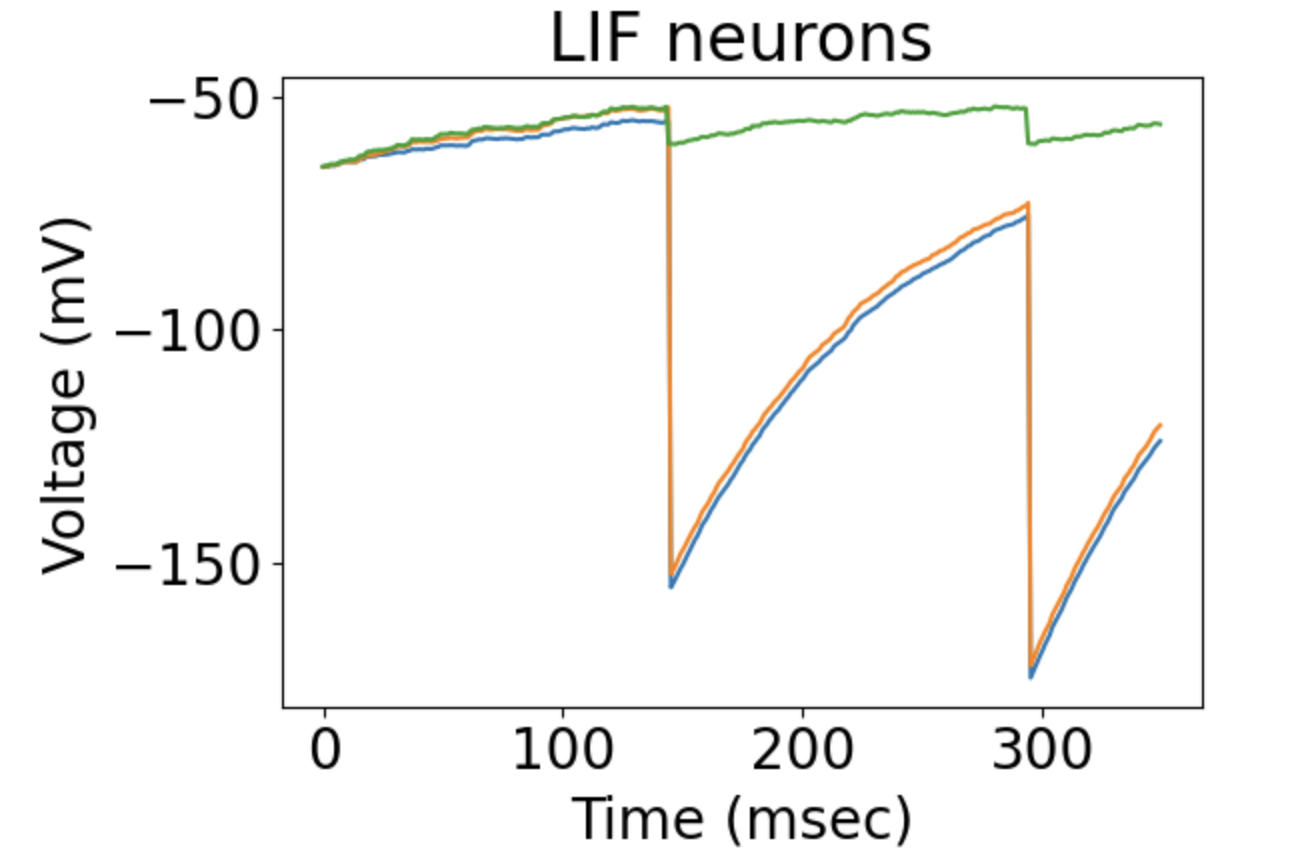

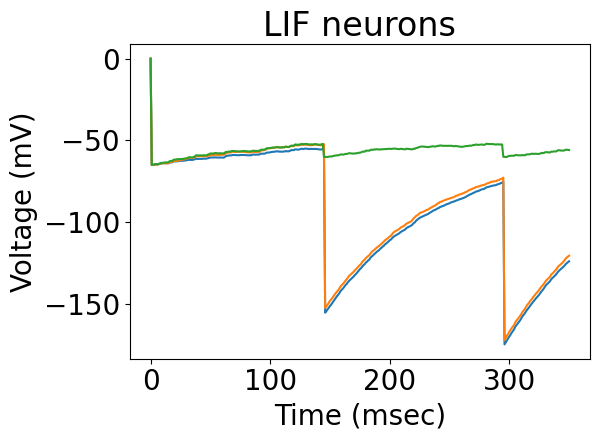

The total spikes produced by your 3 neurons is:
[0 0 2]
and it should be:
[0, 0, 2]


In [28]:
net.reset_state()
net.reset_adaptive_threshold()
np.random.seed(0)
x = 128*np.random.random(size=(11,))
spike_rec = net.simulate(x, plot_sample_voltage=True)
print('The total spikes produced by your 3 neurons is:')
print(spike_rec.sum(axis=0))
print('and it should be:')
print([0, 0, 2])


#### Test: MNIST sample

In your voltage plot, you should see sets of "zig-zag" curves:
- one that drops to be quite small (near ~-1500mV!)
- one that hovers around the resting voltage (~-60 mV).

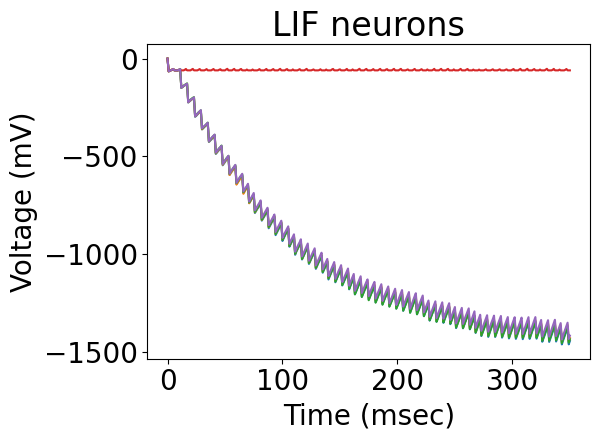

Spikes produced by each recurrent neuron:
[ 0  0  1 59  0]
and it should be (approximately):
[ 0  0  1 59  0]


In [30]:
# Override number of neurons appropriate for MNIST
params['input_layer']['num_neurons'] = 784  
params['recurrent_layer']['num_neurons'] = 5 
# Create the SNN
np.random.seed(0)  # KEEP ME
net = SpikingNet(all_params=params)
# Simulate 1st MNIST sample
spike_rec = net.simulate(mnist_debug['x_debug'][0], plot_sample_voltage=True)
print('Spikes produced by each recurrent neuron:')
print(spike_rec.sum(axis=0))
print('and it should be (approximately):')
print('[ 0  0  1 59  0]')

### 8d. Questions

**Question 3:** Why does the voltage of some cells stay around the rest level while others plummet to get very negative?

**Answer 3:**
It could be the input strength into the neurons. Some obtain strong input therefore they will maintain there voltage values as they fire more frequently. Others who don't obtain as much strong input only fire abit and therefore slowly plumment but we can still see the zig-zag pattern as they fall off from firing just alot less frequently than the neurons that hover over -60. 